In [1]:
# Notebook imports
import numpy as np
import vegavis.api as api
import ipywidgets as widgets
from IPython.display import display
from vegavis.utils import Side, probability_of_trading, num_from_padded_int
from matplotlib import pyplot as plt

In [2]:
# Pull mainnet markets and create a dropdown widget
markets = api.markets.list_markets()
widget = widgets.Dropdown(
    options=list(markets.keys()),
    value="4e9081e20e9e81f3e747d42cb0c9b8826454df01899e6027a22e771e19cc79fc",
    description="Market",
    disabled=False,
)
display(widget)

Dropdown(description='Market', index=4, options=('ab9ffcfe46e3f01e9d8f105832b6e13855b81c06be1cd0f208d1d08a13e1…

In [3]:
# Pull market data
market_id = widget.value
market_info = markets[market_id]
market_data = api.markets.get_latest_market_data(market_id=market_id)
# Extract best prices and bounds
mid_price = int(market_data["midPrice"])
best_bid_price = int(market_data["bestBidPrice"])
best_ask_price = int(market_data["bestOfferPrice"])
min_valid_price = +np.inf
max_valid_price = -np.inf
for bound in market_data["priceMonitoringBounds"]:
    if int(bound["minValidPrice"]) < min_valid_price:
        min_valid_price = int(bound["minValidPrice"])
    if int(bound["maxValidPrice"]) > max_valid_price:
        max_valid_price = int(bound["maxValidPrice"])
# Extract decimals and risk parameters
decimals = int(markets[market_id]["decimalPlaces"])
risk_model = markets[market_id]["tradableInstrument"]["logNormalRiskModel"]
tau = float(risk_model["tau"])
mu = float(risk_model["params"]["mu"])
r = float(risk_model["params"]["r"])
sigma = float(risk_model["params"]["sigma"])
price_range = float(markets[market_id]["liquiditySlaParams"]["priceRange"])

In [13]:
max_bps = widgets.FloatSlider(
    min=0,
    max=1000,
    value=350,
    description="Max Bps.",
    disabled=False,
)
display(max_bps)

FloatSlider(value=350.0, description='Max Bps.', max=1000.0)

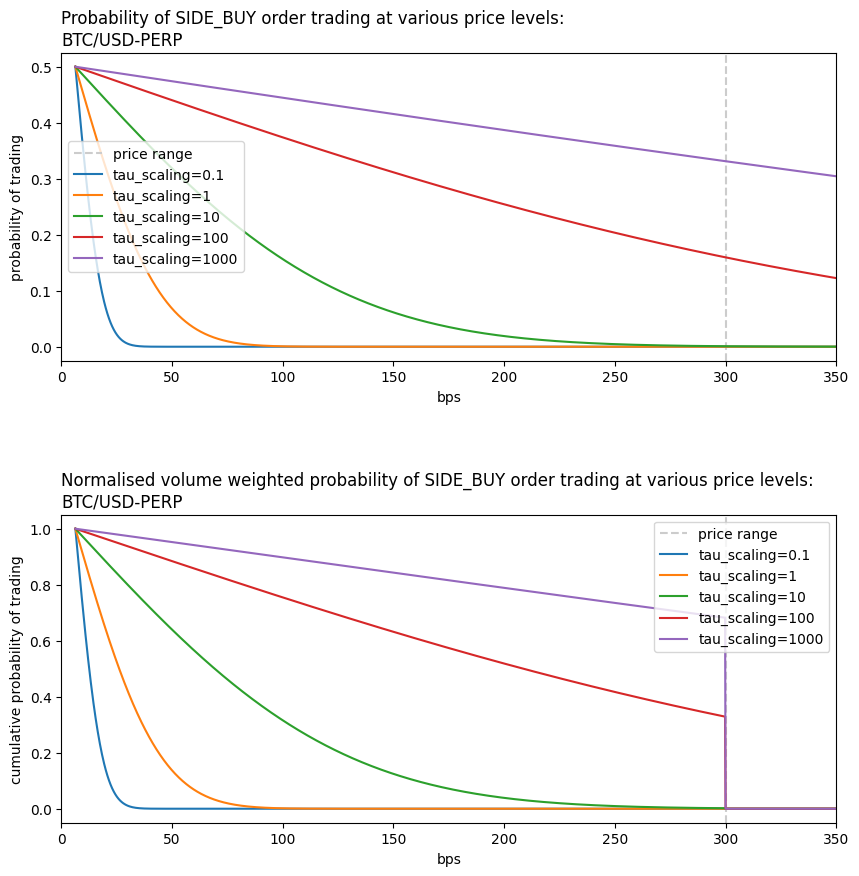

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

side = Side.SIDE_SELL
price_range_limit = mid_price + mid_price * price_range
for ax in axs:
    ax.axvline(
        (price_range_limit - mid_price) / mid_price / 0.0001,
        color=[0.8, 0.8, 0.8],
        linestyle="--",
        label="price range",
    )
for tau_scaling in [0.1, 1, 10, 100, 1000]:
    basis_points = []
    probabilities = []
    volume_weighted = []
    cumulative_volume_weighted = []
    cumulative_contribution = []
    for price in range(best_ask_price, max_valid_price, 10):
        basis_points.append((price - mid_price) / mid_price / 0.0001)
        p = probability_of_trading(
            side=side,
            price=num_from_padded_int(price, decimals),
            best_bid_price=num_from_padded_int(best_bid_price, decimals),
            best_ask_price=num_from_padded_int(best_ask_price, decimals),
            min_valid_price=num_from_padded_int(min_valid_price, decimals),
            max_valid_price=num_from_padded_int(max_valid_price, decimals),
            mu=mu,
            tau=tau,
            sigma=sigma,
            min_probability_of_trading=0,
            tau_scaling=tau_scaling,
        )
        probabilities.append(p)
        volume_weighted.append(
            num_from_padded_int(price, decimals) * p if price < price_range_limit else 0
        )
    axs[0].plot(basis_points, probabilities, label=f"tau_scaling={tau_scaling}")
    axs[1].plot(basis_points, volume_weighted/max(volume_weighted), label=f"tau_scaling={tau_scaling}")

axs[0].set_title(
    f"Probability of SIDE_BUY order trading at various price levels:\n{markets[market_id]['tradableInstrument']['instrument']['code']}",
    loc="left",
)
axs[0].set_xlabel("bps")
axs[0].set_ylabel("probability of trading")
axs[0].set_xlim(0, max_bps.value)
axs[0].legend()

axs[1].set_title(
    f"Normalised volume weighted probability of SIDE_BUY order trading at various price levels:\n{markets[market_id]['tradableInstrument']['instrument']['code']}",
    loc="left",
)
axs[1].set_xlabel("bps")
axs[1].set_xlim(0, max_bps.value)
axs[1].set_ylabel("cumulative probability of trading")
axs[1].legend()


plt.show()